# Landcover Classification 

## Authored by: Blake Marshall, Sean Farmer, Jacob Sellers, & Isauro Ramos

The Landcover Classification project aims to... <CONTINUE DESCRIPTION>

## Setup

### Install Dependencies

In [ ]:
%pip install gdal
%pip install rasterio
%pip install raster2xyz
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install tensorflow
%pip install tabulate
%pip install scikit-image
%pip install openpyxl


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 

### Import Dependencies

In [322]:
# File and directory handling
import os
import shutil
from os import listdir
from os.path import isfile, join

# Data handling and processing
import pandas as pd
import numpy as np
from collections import Counter

# Raster and image processing
import rasterio
from rasterio.plot import show
from raster2xyz.raster2xyz import Raster2xyz
from skimage.transform import resize

# Machine learning and data preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

## Handling Data

### Example Paths To Data & Label Files

In [323]:
path_samples = 'Data/Images/'
file_name = '1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'
path_test_tiff = path_samples + file_name


### Peek To See Shape Of Data


In [324]:
dataset_1 = rasterio.open(path_test_tiff)

# Number of Bands
print(dataset_1.count)
# Image Resolution
print(dataset_1.height, dataset_1.width)
# CRS (Coordinate Reference System)
print(dataset_1.crs)

373
10 10
EPSG:32734


#### From this, we can see that the image has a resolution of 10X10 and consists of 373 bands.

## Visualizing An Image

(373, 10, 10)


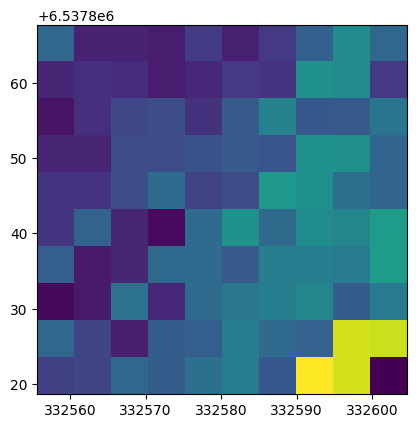

In [325]:
# Open the GeoTIFF file
with rasterio.open(path_test_tiff) as dataset:
    # Read the data as a numpy array
    data_3D = dataset.read()

    # Print the data
    print(data_3D.shape)

    # Visualize the data
    show(dataset)

#### This Image Contains All 373 Bands And Its Not Very Informative. Let's Try Something More Faimilar - Red, Green, & Blue (RGB).

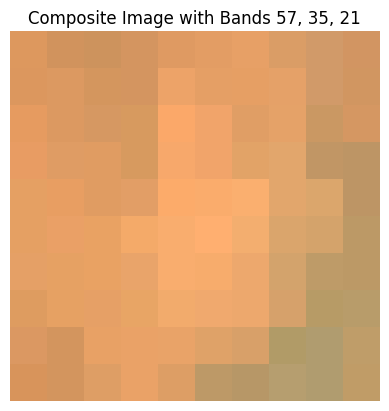

In [326]:
with rasterio.open(path_test_tiff) as dataset:
    # Read the bands as numpy arrays
    band_57 = dataset.read(57)  # Adjust with correct band number
    band_35 = dataset.read(35)  # Adjust with correct band number
    band_21 = dataset.read(21)  # Adjust with correct band number

    # Stack the bands to form a 3-channel (RGB) image
    rgb_image = np.stack([band_57, band_35, band_21], axis=-1)
    # Normalize the values (optional, depending on the image data scale)
    rgb_image = rgb_image / np.max(rgb_image)  # Normalize to [0, 1]

    # Plot the image
    plt.imshow(rgb_image)
    plt.title("Composite Image with Bands 57, 35, 21")
    plt.axis('off')  # Turn off axis
    plt.show()

#### Now that we have an understanding of the data, we can begin work on the entire dataset.

## Implement Funcitions To Unpack Data

In [327]:
def tiff_to_arr(filepath):
  '''
  Description:
    This function takes a filepath to a .tiff file, opens it, and reads it as a
    numpy arr. Then returns said array.
  Input:
    filepath  : The file path to the .tiff file, starting from /content/...
  Output:
    data_3D   : A 3 dimensional array of frequency bands for the pixels of an
                image.
  '''
  with rasterio.open(filepath) as dataset:
      # Read the data as a numpy array
      data_3D = dataset.read()
  return data_3D

In [328]:
def get_filenames(directory_path):
    '''
     * Description:
     *   gets the name of both files and directories at path_samples
     *   sorted by the first numeric prefix in the filename
     * Input(s):
     *   directory_path: the path to the directory containing sample files
     * Output(s):
     *   Sorted Numpy Array of Filenames, array of strings
    '''
    filenames = []
    for f in listdir(directory_path):
        # Ignore hidden files and directories (like .DS_Store)
        if f.startswith(".") or not isfile(join(directory_path, f)):
            continue

        try:
            # Try to parse the first part of the filename as an integer
            int(f.split("_")[0])
            filenames.append(f)  # Only add to the list if parsing succeeds
        except ValueError:
            print(f"Non-numeric prefix found in filename: {f}")  # Print any problematic filename

    # Sort the valid filenames and convert to a numpy array
    return np.array(sorted(filenames, key=lambda x: int(x.split("_")[0])))

# PCA

#### Given that we have 373 bands per image, this data can be hard to work with. To remedy this, we can use Principal Component Analysis (PCA). With PCA, Only the bands, or frequencies, with the most significant variance will been kept - the rest discarded

##### **Note:** From this point forward, the terms "band" and "frequency" will be used interchangeably as they represent the same thing.

## Setup Functions For DataFrame Generation, Data Manipulation, etc. 

In [329]:
def pca_make_pandas_dataframe(dir_path, filename, col_labels):
    ds = tiff_to_arr(join(dir_path, filename))  # shape is (373, 10, 10)

    # Reshape to have each pixel position with 373 band values as a row
    reshaped_ds = ds.reshape(ds.shape[0], -1).T  # Shape becomes (100, 373) or (121, 373) depending on the data
    print(f"reshaped_ds shape: {reshaped_ds.shape}")  # Check shape of reshaped_ds

    # Create the DataFrame with band columns
    df = pd.DataFrame(reshaped_ds, columns=col_labels[:reshaped_ds.shape[1]])

    # Dynamically generate X and Y coordinates based on the number of rows in reshaped_ds
    num_rows = reshaped_ds.shape[0]
    x_vals = np.tile(np.arange(10), num_rows // 10)
    y_vals = np.repeat(np.arange(10), num_rows // 10)

    # Adjust lengths in case of rounding issues
    if len(x_vals) != num_rows:
        x_vals = np.resize(x_vals, num_rows)
    if len(y_vals) != num_rows:
        y_vals = np.resize(y_vals, num_rows)

    # Check if lengths match
    print(f"Length of X: {len(x_vals)}, Length of Y: {len(y_vals)}, Num Rows: {num_rows}")
    
    df['X'] = x_vals  # X coordinates
    df['Y'] = y_vals  # Y coordinates

    # Add filename for tracking
    df['File'] = filename

    return df

In [330]:
def pca_get_all_data(sample_directory_path):
  #Creates the frequency labels
  columns_of_frequencies = []
  for i in range(0,373,1):
    columns_of_frequencies.append("frq" + str(i))

  # get an array of the sample file names
  filenames = get_filenames(sample_directory_path)

  ## This is where we would trim the filenames for the ones we want

  #loop through and add to pandas dataframe
  list_df = []
  for i in range(0, len(filenames)):
    list_df.append(pca_make_pandas_dataframe(sample_directory_path, filenames[i], columns_of_frequencies))
    #print(i)

  return pd.concat(list_df)

In [331]:
df = pca_get_all_data(path_samples) 

reshaped_ds shape: (100, 373)
Length of X: 100, Length of Y: 100, Num Rows: 100
reshaped_ds shape: (100, 373)
Length of X: 100, Length of Y: 100, Num Rows: 100
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (144, 373)
Length of X: 144, Length of Y: 144, Num Rows: 144
reshaped_ds shape: (132, 373)
Length of X: 132, Length of Y: 132, Num Rows: 132
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of 

### Visualizing the DataFrame

In [332]:
df

,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,frq8,frq9,...,frq366,frq367,frq368,frq369,frq370,frq371,frq372,X,Y,File
0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,0.039591,0.044717,...,0.154068,0.154073,0.158080,0.160214,0.164343,0.173604,0.190160,0,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,0.039005,0.042359,...,0.143804,0.146481,0.146843,0.155816,0.159489,0.157601,0.169750,1,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,0.039349,0.043371,...,0.145602,0.146007,0.148808,0.149374,0.162757,0.157468,0.167964,2,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,0.040206,0.042641,...,0.149051,0.150941,0.147344,0.155273,0.154464,0.140058,0.165022,3,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,0.040920,0.043962,...,0.158802,0.157301,0.157921,0.164166,0.162148,0.151324,0.178857,4,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.110040,0.113846,0.122912,0.129257,0.133967,0.136724,0.142878,0.143184,0.149973,0.154388,...,0.077318,0.082198,0.073062,0.078871,0.106960,0.102698,0.037319,9,9,12128_ang20231031t091505_002_L2A_OE_main_27577...
60,0.090576,0.097904,0.101751,0.106854,0.110958,0.114553,0.118870,0.120013,0.125182,0.128634,...,0.048856,0.052119,0.038128,0.048034,0.072314,0.085504,0.048451,0,0,12128_ang20231031t091505_002_L2A_OE_main_27577...
61,0.109015,0.110967,0.114204,0.122206,0.125042,0.129206,0.131949,0.135035,0.139115,0.144689,...,0.063514,0.068835,0.070935,0.068684,0.062232,0.069433,0.070832,1,0,12128_ang20231031t091505_002_L2A_OE_main_27577...
62,0.127796,0.130344,0.136902,0.146922,0.151861,0.154839,0.158604,0.158993,0.164166,0.167904,...,0.088122,0.088683,0.088928,0.091659,0.105230,0.131382,0.131696,2,0,12128_ang20231031t091505_002_L2A_OE_main_27577...


##### Again, as we can see from the above dataframe, prior to PCA being performed, each pixel has 373 frequencies.

### Reshape and Manipulate Data For PCA

##### The dataframe is not currently compatible with PCA. Let's remove nonumeric columns, remove NaNs, etc.

In [333]:
# Drop non-numeric columns like 'X', 'Y', and 'File'
features = df.drop(columns=['X', 'Y', 'File'])

# Standardize the data (if features have different scales)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert the NumPy array to a pandas DataFrame and preserve the original index
features_scaled_df = pd.DataFrame(features_scaled, index=df.index) 

# Drop rows with any NaN values, while preserving the index
features_scaled_dropped = features_scaled_df.dropna()

# Verify the row count of features_scaled_dropped and df
print(f"features_scaled_dropped rows: {len(features_scaled_dropped)}")
print(f"Original df rows: {len(df)}")

features_scaled_dropped rows: 395034
Original df rows: 415959


In [334]:
# Initialize PCA and reduce to 2 principal components
pca = PCA(n_components=2)  # Adjust the number of components if needed
principal_components = pca.fit_transform(features_scaled_dropped)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Check the index length after dropping NaNs
print(f"pca_df rows: {len(pca_df)}")

# Reset the index of df if it has a custom index
df_reset = df.reset_index(drop=True)

# Align the rows of df with the rows that remain in features_scaled_dropped
pca_df['X'] = df_reset.loc[features_scaled_dropped.index, 'X'].values
pca_df['Y'] = df_reset.loc[features_scaled_dropped.index, 'Y'].values
pca_df['File'] = df_reset.loc[features_scaled_dropped.index, 'File'].values

pca_df rows: 395034


In [335]:
# Show the first few rows of the PCA result
print(pca_df.head())

        PC1       PC2  X  Y                                               File
0  4.059567 -6.072723  0  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
1  2.154698 -6.107913  1  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
2  1.647049 -6.058152  2  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
3  2.442465 -6.234372  3  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
4  4.533383 -6.185866  4  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...


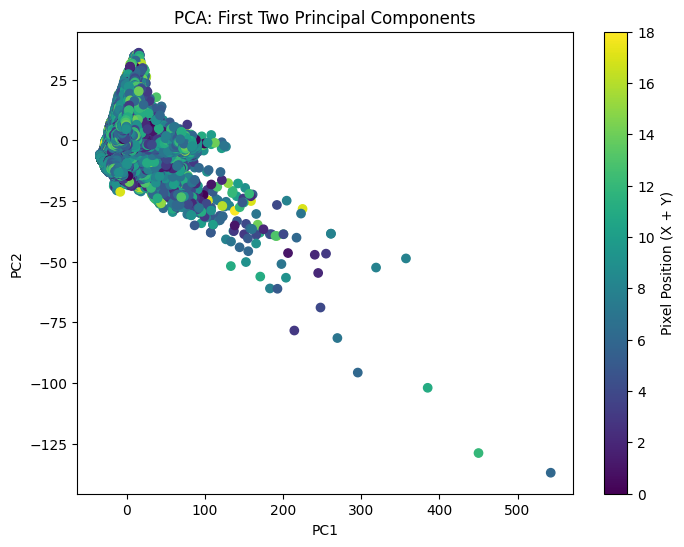

Explained variance ratio for each component: [0.751734   0.14358872]


In [336]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['X'] + pca_df['Y'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Pixel Position (X + Y)')
plt.show()

# Explained variance ratio
print(f'Explained variance ratio for each component: {pca.explained_variance_ratio_}')

#### Here is an example of the result to PCA with two components. We can see that the first two components contain nearly 90% of the variance! We'd like a little more - let's keep trying.

### Plotting PCA Components

##### Let's plot a graph that will show us the necessary number of components for a specific amount of variance.

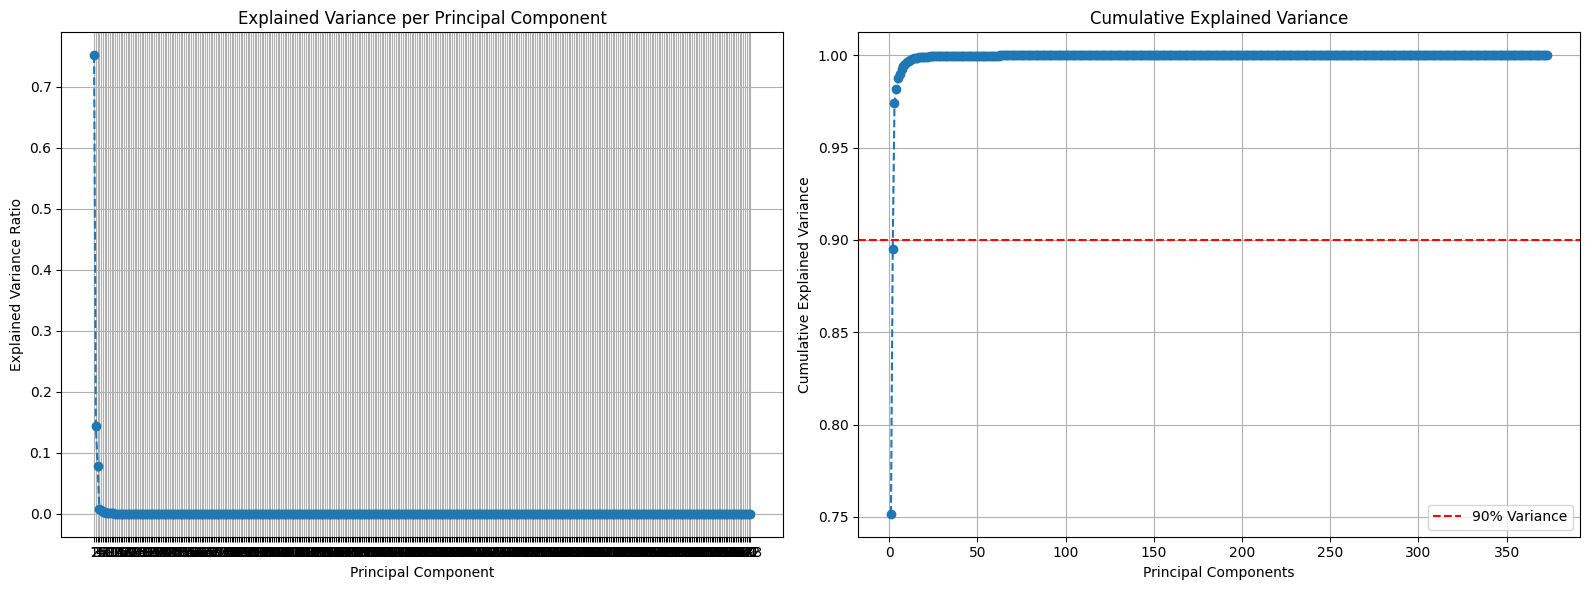

In [337]:
# Assuming features_scaled_dropped is your pre-processed data
pca_full = PCA()
principal_components_full = pca_full.fit_transform(features_scaled_dropped)
explained_variance_ratio_full = pca_full.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio_full)

# Create a 1x2 subplot (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust the figsize as needed

# Plot the explained variance ratio for all components
axes[0].plot(range(1, len(explained_variance_ratio_full) + 1), explained_variance_ratio_full, marker='o', linestyle='--')
axes[0].set_title('Explained Variance per Principal Component')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_xticks(range(1, len(explained_variance_ratio_full) + 1))
axes[0].grid(True)

# Plot the cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
axes[1].axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### It looks like we'll need to use three principal components in order to achieve 90%+ variance. Let's try this agian.

In [338]:
# Determine the number of components to explain 90% of the variance
pca = PCA(n_components=0.90)  # Keep enough components to explain 90% variance
principal_components = pca.fit_transform(features_scaled_dropped)
explained_variance_ratio = pca.explained_variance_ratio_

print(f"Number of components to explain 90% variance: {pca.n_components_}")

Number of components to explain 90% variance: 3


In [339]:
# Access the component loadings (how much each feature contributes to each component)
component_loadings = pca.components_

# Convert it to a DataFrame for easier inspection
loadings_df = pd.DataFrame(component_loadings, columns=features.columns)

# For each component, get the top 6 features with the highest absolute loadings
top_n = pca.n_components_
top_features = {}

for i in range(loadings_df.shape[0]):  # Loop through each component
    # Sort the values by absolute magnitude and get the top 6
    sorted_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False).head(top_n)
    top_features[f"Component {i+1}"] = sorted_loadings

# Convert the result to a DataFrame for better presentation
top_features_df = pd.DataFrame(top_features)

# Print the top 6 features for each component
print(top_features_df)

        Component 1  Component 2  Component 3
frq100          NaN     0.086242          NaN
frq102          NaN     0.086200          NaN
frq253     0.058133          NaN          NaN
frq254     0.058138          NaN          NaN
frq255     0.058146          NaN          NaN
frq3            NaN          NaN     0.128541
frq4            NaN          NaN     0.128608
frq5            NaN          NaN     0.128622
frq99           NaN     0.086271          NaN


In [340]:
# Create a set to store the distinct frequencies used in the top features
used_frequencies = set()

# Loop through each component and add the top N frequencies to the set
for i in range(loadings_df.shape[0]):  # Loop through each component
    # Get the top features for the component by sorting by absolute magnitude
    sorted_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False).head(top_n)
    # Add the indices (frequencies) of these top features to the set
    used_frequencies.update(sorted_loadings.index)

# Count the total number of unique frequencies used
total_used_frequencies = len(used_frequencies)

# Print the total number of unique frequencies
print(f"Total number of frequencies used across all components: {total_used_frequencies}")

# Print the names of the features (frequencies) used
print("\nFrequencies used across all components:")
for feature in used_frequencies:
    print(feature)

Total number of frequencies used across all components: 9

Frequencies used across all components:
frq253
frq4
frq3
frq5
frq102
frq99
frq254
frq255
frq100


### Add Principal Components To Data

##### Let's create a new dataframe that uses the three princiapl components, rather the 373 bands.

In [341]:
def add_principal_components(pca, principal_components):
    # Convert the principal components to a DataFrame
    principal_components_df = pd.DataFrame(
        principal_components, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    # Reset the index for consistency
    principal_components_df = principal_components_df.reset_index(drop=True)

    # Reset index in df to align with features_scaled_dropped
    df_reset = df.reset_index(drop=True)

    # Select 'X', 'Y', and 'File' columns from df
    xy_file_df = df_reset[['X', 'Y', 'File']].iloc[:len(principal_components_df)].reset_index(drop=True)

    # Concatenate the selected columns with the principal components
    return pd.concat([xy_file_df, principal_components_df], axis=1)

##### Let's visualize the dataframe. We should see that each pixel contains 3 principal components and no additional frequencies. 

In [342]:
data_with_pcs = add_principal_components(pca, principal_components)
# Print the first 100 rows of the new dataset to verify
print(data_with_pcs.head())

   X  Y                                               File       PC1  \
0  0  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  4.059567   
1  1  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  2.154698   
2  2  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  1.647049   
3  3  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  2.442465   
4  4  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  4.533383   

        PC2       PC3  
0 -6.072723  0.702673  
1 -6.107913  0.824778  
2 -6.058152  0.914244  
3 -6.234372  0.884735  
4 -6.185866  0.665055  


### Visualizing an image

In [343]:
# Step 1: Extract the first 100 pixels, each with 3 components
# Assuming data_with_pcs is a DataFrame with columns PC1, PC2, PC3 for each pixel
first_100_pixels = data_with_pcs[['PC1', 'PC2', 'PC3']].iloc[:100].values  # First 100 pixels with 3 components each

# Step 2: Reshape the data to 10x10x3 (image_dim x image_dim x 3 components per pixel)
image_dim = 10  # 10x10 image
reconstructed_image = first_100_pixels.reshape(image_dim, image_dim, 3)  # 3 components per pixel

# Step 3: Combine the 3 components into a single grayscale image (for simplicity)
combined_image = np.mean(reconstructed_image, axis=-1)  # Averaging the 3 components for grayscale



#### Now, let's view the first image in the dataset after PCA. We will compare it to the same image prior to PCA.

(373, 10, 10)


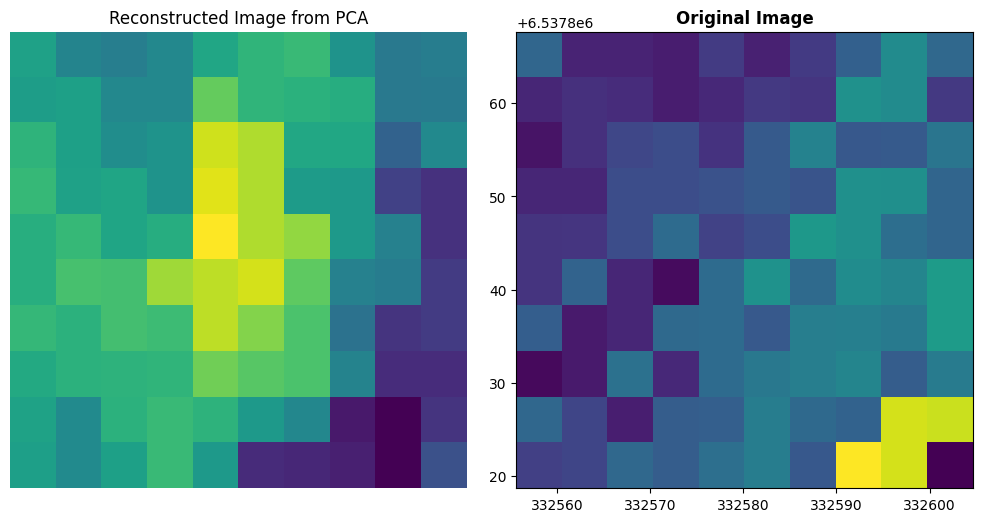

In [344]:
# Create a figure for the plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns, adjust figure size

# Subplot 1: Reconstructed Image from PCA
axes[0].imshow(combined_image, aspect='equal')  # Maintain aspect ratio
axes[0].set_title('Reconstructed Image from PCA')
axes[0].axis('off')  # Remove axes for clean display

# Subplot 2: Rasterio Visualization
with rasterio.open(path_test_tiff) as dataset:
    data_3D = dataset.read()  # Read the data as a numpy array
    print(data_3D.shape)  # Print the shape of the 3D array

    # Visualize the data using Rasterio
    show(dataset, ax=axes[1], title='Original Image')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

#### Success! From this, we can see that there are new identifiable features! Let's try another for good measure.

###### Add PCA with 2,3,4 here. 

## Setup For Computer Vision Models

### Process Labels

In [357]:
# Load the Excel file
excel_file = 'Labels/CNN_Sample_Boxes_Subset_241018.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file, sheet_name=5)

# Display the first few rows
print(df.head())

# Access specific columns
image_numbers = df['Sample_num']
labels = df['Class']

# Access specific rows
first_row = df.iloc[0]  # First row as a Series
first_value = df.iloc[0, 0]  # First cell value

# Iterate over rows
#for index, row in df.iterrows():
   # print(f"Sample_num: {row['Sample_num']}, Label: {row['Class']}")


   Sample_num                                   Class Notes
0         1.0                   Unconsolidated Barren   NaN
1         2.0                   Unconsolidated Barren   NaN
2         3.0  Consolidated Barren (rocks, salt pans)   NaN
3         4.0                Annual Crops (e.g wheat)   NaN
4         5.0                Annual Crops (e.g wheat)   NaN


In [358]:
def assign_images_to_samples(image_folder, labels_excel, output_folder, sheet_index=5):
    """
    Assigns images to each Sample_num and Class pair from the DataFrame,
    matching the filenames exactly to the format Sample_num + "_".

    Args:
    - image_folder (str): Path to the folder containing the images.
    - labels_excel (str): Path to the Excel file containing Sample_num and Class labels.
    - output_folder (str): Path to the output folder where organized data will be saved.
    - sheet_index (int): Index of the sheet to read from the Excel file.

    Returns:
    - None
    """
    # Read the specified sheet from the Excel file
    df = pd.read_excel(labels_excel, sheet_name=sheet_index)

    # Convert Sample_num to integers, then to strings
    df['Sample_num'] = df['Sample_num'].apply(lambda x: str(int(x)) if not pd.isna(x) else None)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        sample_num = row['Sample_num']
        label = row['Class']

        if sample_num is None:
            print(f"Skipping row {index} with missing Sample_num")
            continue

        # Find the matching image in the image folder
        assigned_image = None
        for image_file in os.listdir(image_folder):
            # Match files that start with Sample_num followed by "_"
            if image_file.startswith(f"{sample_num}_") and image_file.lower().endswith(('.tif', '.jpg', '.jpeg', '.png')):
                assigned_image = image_file
                break

        # Check if an image was found
        if assigned_image:
            # Create a subdirectory for the label if it doesn't exist
            label_folder = os.path.join(output_folder, str(label))
            os.makedirs(label_folder, exist_ok=True)

            # Copy the image to the appropriate label folder
            source_path = os.path.join(image_folder, assigned_image)
            destination_path = os.path.join(label_folder, assigned_image)
            shutil.copy(source_path, destination_path)
        else:
            print(f"No image found for Sample_num {sample_num}")

    print(f"Images organized into {output_folder}.")

# Example usage
assign_images_to_samples(
    image_folder="Data/Images",
    labels_excel="Labels/CNN_Sample_Boxes_Subset_241018.xlsx",
    output_folder="Organized_Images/"
)


No image found for Sample_num 263
No image found for Sample_num 264
No image found for Sample_num 1054
No image found for Sample_num 1055
No image found for Sample_num 1056
No image found for Sample_num 1162
No image found for Sample_num 1169
No image found for Sample_num 1180
No image found for Sample_num 1181
No image found for Sample_num 1184
No image found for Sample_num 1229
No image found for Sample_num 1238
No image found for Sample_num 1248
No image found for Sample_num 1249
No image found for Sample_num 1250
No image found for Sample_num 1251
No image found for Sample_num 1255
No image found for Sample_num 1256
No image found for Sample_num 1257
No image found for Sample_num 1258
No image found for Sample_num 1259
No image found for Sample_num 1260
No image found for Sample_num 1261
No image found for Sample_num 1262
No image found for Sample_num 1272
No image found for Sample_num 1273
No image found for Sample_num 1274
No image found for Sample_num 1276
No image found for Sam

In [359]:
def get_labels_from_folder(organized_folder):
    """
    Extract labels and file paths from the organized folder.

    Args:
    
    organized_folder (str): Path to the folder with subfolders as class labels.

        Returns:
        
    filenames (list): List of file paths.
    labels (list): List of corresponding class labels."""
    filenames = []
    labels = []

    # Iterate through subfolders
    for label_folder in os.listdir(organized_folder):
        label_path = os.path.join(organized_folder, label_folder)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for file in os.listdir(label_path):
                if file.lower().endswith(('.tif')):
                    filenames.append(os.path.join(label_path, file))
                    labels.append(label_folder)  # Use string label directly

    return filenames, labels

In [360]:
organized_folder = "Organized_Images/"
#Get file paths and string labels
filepaths, string_labels = get_labels_from_folder(organized_folder)

#Encode string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(string_labels)

#Ensure actual_labels matches the number of samples
print(f"Number of files: {len(filepaths)}, Number of labels: {len(string_labels)}")

#Print mapping of string labels to integers (optional)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

Number of files: 1620, Number of labels: 1620
Label mapping: {np.str_('Annual Crops (e.g wheat)'): np.int64(0), np.str_('Built-up'): np.int64(1), np.str_('Consolidated Barren (rocks, salt pans)'): np.int64(2), np.str_('Mixed or Not Classified'): np.int64(3), np.str_('Natural Grassland'): np.int64(4), np.str_('Natural Wooded Land'): np.int64(5), np.str_('Permanent Crops (e.g., vineyard)'): np.int64(6), np.str_('Planted Forest'): np.int64(7), np.str_('Shrubs'): np.int64(8), np.str_('Unconsolidated Barren'): np.int64(9), np.str_('Waterbodies'): np.int64(10), np.str_('Wetlands'): np.int64(11)}


### Label Frequency

In [361]:
# Count frequency of each label
label_counts = Counter(y)

# Map back to string labels for better interpretability
string_label_counts = {label_encoder.inverse_transform([k])[0]: v for k, v in label_counts.items()}

# Prepare data for the table
table_data = [(label, count) for label, count in string_label_counts.items()]
headers = ["Label", "Frequency"]

# Display as a table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+----------------------------------------+-------------+
| Label                                  |   Frequency |
+========================================+=============+
| Consolidated Barren (rocks, salt pans) |         119 |
+----------------------------------------+-------------+
| Wetlands                               |           5 |
+----------------------------------------+-------------+
| Permanent Crops (e.g., vineyard)       |          19 |
+----------------------------------------+-------------+
| Natural Grassland                      |         226 |
+----------------------------------------+-------------+
| Built-up                               |         107 |
+----------------------------------------+-------------+
| Annual Crops (e.g wheat)               |         148 |
+----------------------------------------+-------------+
| Natural Wooded Land                    |         232 |
+----------------------------------------+-------------+
| Waterbodies                  

In [362]:
# Track labels with less than 50 occurrences
infrequent_labels = {k: v for k, v in string_label_counts.items() if v < 50}

# Prepare data for the table
infrequent_labels = [(label, count) for label, count in infrequent_labels.items()]
headers = ["Label", "Frequency"]

# Display as a table
if infrequent_labels:
    print("\nLabels with fewer than 50 occurrences:")
    print(tabulate(infrequent_labels, headers=headers, tablefmt="grid"))
else:
    print("\nNo labels with fewer than 50 occurrences.")


Labels with fewer than 50 occurrences:
+----------------------------------+-------------+
| Label                            |   Frequency |
+==================================+=============+
| Wetlands                         |           5 |
+----------------------------------+-------------+
| Permanent Crops (e.g., vineyard) |          19 |
+----------------------------------+-------------+
| Planted Forest                   |          20 |
+----------------------------------+-------------+


In [363]:
def remove_infrequent_labels(X, y, min_frequency=50):
    """
    Remove or ignore rows from X and y with labels that occur less than min_frequency times.

    Parameters:
        X (numpy.ndarray): Input data array.
        y (numpy.ndarray): Label array.
        min_frequency (int): Minimum frequency for a label to be retained.

    Returns:
        X_filtered (numpy.ndarray): Filtered input data.
        y_filtered (numpy.ndarray): Filtered labels.
    """
    # Count label frequencies
    label_counts = Counter(y)
    
    # Identify labels with sufficient frequency
    valid_labels = {label for label, count in label_counts.items() if count >= min_frequency}
    
    # Filter X and y
    indices_to_keep = [i for i, label in enumerate(y) if label in valid_labels]
    X_filtered = X[indices_to_keep]
    y_filtered = y[indices_to_keep]
    
    return X_filtered, y_filtered


# Micro CNN

In [364]:
# Step 1: Prepare the input and labels
num_samples = len(data_with_pcs)
#print(num_samples)


# Extract the first three principal components as features
X = data_with_pcs[['PC1', 'PC2', 'PC3']].values
y = LabelEncoder().fit_transform(string_labels)  # Encode labels if they are categorical


#print(f"Original shape of X: {X.shape}")
#print(f"Total elements in X: {X.size}")


# Determine number of valid samples
num_samples = X.shape[0] // 100  # Each sample needs 10x10=100 rows

# Truncate and reshape
num_samples = len(y)
X = X[:num_samples * 100]        # Truncate extra rows
X = X.reshape(num_samples, 10, 10, 3)  # Reshape to (num_samples, 10, 10, 3)

# Adjust labels
y = y[:num_samples]

#print(f"New shape of X: {X.shape}")  # Should be (num_samples, 10, 10, 3)
#print(f"New length of y: {len(y)}")

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y[:num_samples], test_size=0.2, random_state=42, stratify=y,)

# Remove data with labels with frequency < 50
'''
X_filtered, y_filtered = remove_infrequent_labels(X, y, min_frequency=50)

# Proceed with train-test split on the filtered data
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)
'''

# Step 2: Define a simple CNN
model = models.Sequential([
    layers.Input(shape=(10, 10, 3)),  # Define input shape explicitly
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_samples, activation='softmax')  # Adjust the output layer for the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 3: Train the model ###This method might take longer to run but provides a high accuracy
kf = KFold(n_splits=5)
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)



print("\n")
# Step 4: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

print("\n")
# Step 5: Use the model to predict
predictions = model.predict(X_test)
print(f"Predictions: {np.argmax(predictions, axis=1)[:10]}")

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1890 - loss: 5.2789 - val_accuracy: 0.3148 - val_loss: 3.6068
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3859 - loss: 1.7560 - val_accuracy: 0.3086 - val_loss: 3.5485
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4149 - loss: 1.6218 - val_accuracy: 0.3549 - val_loss: 3.5759
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4424 - loss: 1.5411 - val_accuracy: 0.3580 - val_loss: 3.7099
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4340 - loss: 1.5164 - val_accuracy: 0.3426 - val_loss: 3.6295
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4394 - loss: 1.5200 - val_accuracy: 0.3611 - val_loss: 3.6023
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4724 - loss: 1.4759 - val_accuracy: 0.3488 - val_loss: 3.5093
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4720 - loss: 1.4033 - val_accuracy: 0.3796 - val_loss:

In [365]:
y_pred = np.argmax(model.predict(X_test), axis=1)
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.81      1.00      0.89        21
           2       0.92      1.00      0.96        24
           3       0.00      0.00      0.00        15
           4       0.92      0.98      0.95        45
           5       0.83      0.98      0.90        46
           6       1.00      1.00      1.00         4
           7       0.00      0.00      0.00         4
           8       0.86      0.90      0.88        80
           9       1.00      0.25      0.40        16
          10       0.73      0.95      0.83        38
          11       1.00      1.00      1.00         1

    accuracy                           0.86       324
   macro avg       0.76      0.75      0.73       324
weighted avg       0.82      0.86      0.83       324



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [366]:
def confMat(model, x_test, y_test, class_names):
    """
    Plots a visual confusion matrix for a given model and test data.

    Args:
    
    model: Trained model to evaluate.
    x_test: Test features.
    y_test: True labels for test data.
    class_names: List of class names corresponding to numerical labels.
    """
    plt.figure(figsize=(15, 5))

    # Predict test images
    predict_x = model.predict(x_test)
    # Get corresponding predicted label
    y_pred = np.argmax(predict_x, axis=1)

    # Generate confusion matrix, ensuring all class labels are included
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plot confusion matrix
    plt.title("Confusion Matrix")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [367]:
#Retrieve class names from the label encoder
class_names = label_encoder.classes_

print(f"Class Names: {class_names}")

Class Names: ['Annual Crops (e.g wheat)' 'Built-up'
 'Consolidated Barren (rocks, salt pans)' 'Mixed or Not Classified'
 'Natural Grassland' 'Natural Wooded Land'
 'Permanent Crops (e.g., vineyard)' 'Planted Forest' 'Shrubs'
 'Unconsolidated Barren' 'Waterbodies' 'Wetlands']


In [368]:
# Only Display Labels With Frequency > 50
'''
# Extract just the label names (from infrequent_labels)
infrequent_labels_set = {label for label, _ in infrequent_labels}

# Remove infrequent labels from label_encoder.classes_
class_names = [class_name for class_name in label_encoder.classes_ if class_name not in infrequent_labels_set]

# Print the result
print(f"Class Names: {class_names}")
'''

'\n# Extract just the label names (from infrequent_labels)\ninfrequent_labels_set = {label for label, _ in infrequent_labels}\n\n# Remove infrequent labels from label_encoder.classes_\nclass_names = [class_name for class_name in label_encoder.classes_ if class_name not in infrequent_labels_set]\n\n# Print the result\nprint(f"Class Names: {class_names}")\n'

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


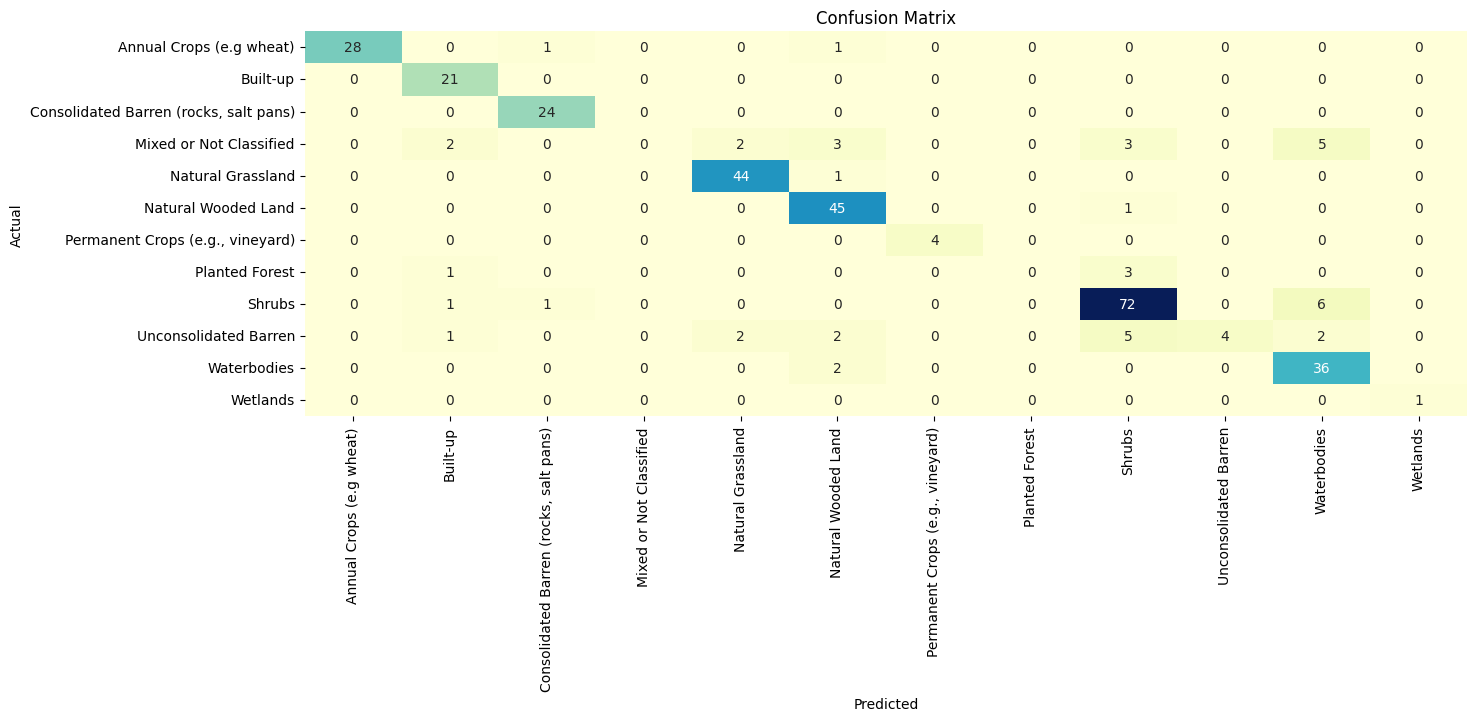

In [369]:
confMat(model, X_test, y_test,class_names)

In [370]:
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best validation accuracy: {best_val_accuracy}")

Best validation accuracy: 0.8734567761421204


# Custom CNN #2

In [371]:
def rgb_make_pandas_dataframe(dir_path, filename, col_labels):
    # Load the 3D data
    ds = tiff_to_arr(join(dir_path, filename))  # Expected shape (373, 10, 10)

    # Check if the dimensions match expected shape
    if ds.ndim != 3:
        raise ValueError(f"Expected 3D input, got shape {ds.shape}")

    # Add file tracking as metadata (optional since we're focusing on 3D data)
    return ds  # Return raw 3D data to be processed later



In [372]:
def rgb_get_all_data(sample_directory_path):
    # Create the frequency labels
    columns_of_frequencies = []
    for i in range(373):  # Assuming 373 bands
        columns_of_frequencies.append(f"frq{i}")

    # Get an array of the sample file names
    filenames = get_filenames(sample_directory_path)

    # Process each file into a 3D array
    list_ds = []
    for filename in filenames:
        ds = tiff_to_arr(join(sample_directory_path, filename))  # Original dataset shape
        
        # Handle NaNs in the data
        ds = np.nan_to_num(ds, nan=0)  # Replace NaNs with 0 (or use `nan=np.nanmean(ds)` for mean replacement)
        
        # Resize if not 10x10
        if ds.shape[1:] != (10, 10):  
            print(f"Resizing dataset {filename} from shape {ds.shape[1:]} to (10, 10)")
            ds = np.array([resize(band, (10, 10), mode='constant', anti_aliasing=True) for band in ds])
        
        list_ds.append(ds)

    # Stack all datasets into a single array (num_samples, bands, 10, 10)
    all_data = np.stack(list_ds, axis=0)  # Shape: (num_samples, bands, 10, 10)

    return all_data


In [373]:
# Load 3D data
all_data = rgb_get_all_data(path_samples)  # Shape: (num_samples, bands, 10, 10)

# Select RGB channels by indices (frq57, frq35, frq21 correspond to indices 57, 35, 21)
rgb_data = all_data[:, [57, 35, 21], :, :]  # Shape: (num_samples, ndim, height, width) (num_samples, 3, 10, 10)

# Rearrange dimensions to match CNN input expectations (num_samples, height, width, ndim)
rgb_data = np.transpose(rgb_data, (0, 2, 3, 1))  # Shape becomes (num_samples, 10, 10, 3)

# Encode string labels into integers
y = LabelEncoder().fit_transform(string_labels)  # Assuming string_labels is aligned with files

# Ensure alignment of data and labels
num_samples = min(rgb_data.shape[0], len(y))
rgb_data = rgb_data[:num_samples]
y = y[:num_samples]

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(rgb_data, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the train and test splits
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Resizing dataset 2_ang20231028t100428_001_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 11) to (10, 10)
Resizing dataset 3_ang20231028t100428_000_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 11) to (10, 10)
Resizing dataset 3_ang20231028t095542_011_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 10) to (10, 10)
Resizing dataset 3_ang20231028t100428_001_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 11) to (10, 10)
Resizing dataset 4_ang20231028t101421_009_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 10) to (10, 10)
Resizing dataset 5_ang20231028t101421_009_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 10) to (10, 10)
Resizing dataset 6_ang20231028t101421_010_L2A_OE_main_27577724_RFL_ORT.tif from shape (10, 11) to (10, 10)
Resizing dataset 6_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif from shape (12, 12) to (10, 10)
Resizing dataset 7_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif from shape (12, 11) to (10, 10)
Resizing dataset 7_ang20231028t101421

In [374]:
print("Shape of rgb_data after slicing:", rgb_data.shape)
print("Sample values after slicing (first sample):", rgb_data[0])


Shape of rgb_data after slicing: (1620, 10, 10, 3)
Sample values after slicing (first sample): [[[0.17019424 0.12054856 0.0741334 ]
  [0.16033167 0.11746091 0.07538021]
  [0.15723258 0.1169846  0.07612375]
  [0.16133104 0.1183662  0.07398973]
  [0.17011483 0.12237453 0.07616287]
  [0.17367806 0.12422083 0.08023376]
  [0.17856775 0.12674335 0.08107708]
  [0.1670087  0.1255973  0.08111847]
  [0.16049336 0.12278292 0.07985374]
  [0.16101064 0.11863639 0.07599197]]

 [[0.16789131 0.11983777 0.07633337]
  [0.17098407 0.12137886 0.0753776 ]
  [0.16173247 0.11899645 0.07303523]
  [0.16133104 0.1183662  0.07398973]
  [0.18224706 0.12906632 0.08400304]
  [0.17599358 0.12648483 0.08024004]
  [0.17604321 0.12679589 0.07994237]
  [0.17568019 0.1285962  0.08145364]
  [0.16049336 0.12278292 0.07985374]
  [0.16074291 0.1184913  0.07768108]]

 [[0.17587258 0.12377473 0.07930376]
  [0.17098407 0.12137886 0.0753776 ]
  [0.16502735 0.12010856 0.07832602]
  [0.16529453 0.12253468 0.07682256]
  [0.1919103 

In [375]:

# Step 2: Define a simple CNN
model = models.Sequential([
    layers.Input(shape=(10, 10, 3)),  # Define input shape explicitly
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_samples, activation='softmax')  # Adjust the output layer for the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 3: Train the model ###This method might take longer to run but provides a high accuracy
kf = KFold(n_splits=5)
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)



print("\n")
# Step 4: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

print("\n")
# Step 5: Use the model to predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1918 - loss: 4.9209 - val_accuracy: 0.2469 - val_loss: 7.1422
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3718 - loss: 1.7833 - val_accuracy: 0.2469 - val_loss: 7.1463
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3844 - loss: 1.6858 - val_accuracy: 0.2469 - val_loss: 7.1497
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4119 - loss: 1.6008 - val_accuracy: 0.2469 - val_loss: 7.0968
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.5853 - val_accuracy: 0.2469 - val_loss: 7.0766
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4468 - loss: 1.5111 - val_accuracy: 0.2469 - val_loss: 7.0386
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4690 - loss: 1.4364 - val_accuracy: 0.2531 - val_loss: 7.0212
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4612 - loss: 1.4430 - val_accuracy: 0.2469 - val_loss:

In [376]:
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 13.58%
